In [1]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import backend as K
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

Using TensorFlow backend.


## Load and Preprocess input image

In [2]:
# Original input image path 
original_img_path = "images/dog.jpg"

# VGG16 was trained on 224x224 image
img = image.load_img(original_img_path, target_size=(224, 224))

# Transform into numpy array
x = image.img_to_array(img)
print("Float32 numpy array of shape: ", x.shape)

Float32 numpy array of shape:  (224, 224, 3)


In [3]:
# Add a dimension
x = np.expand_dims(x, axis=0)

# Channel wise color normalization
x = preprocess_input(x)

In [4]:
# Load pretrained VGG16 model
model = VGG16(weights='imagenet',include_top=True)
layer_name = 'block3_conv1'

## Set up Grad CAM algorithm

In [5]:
# Get top 3 prediction and index of first pred classe
preds = model.predict(x)
class_index = np.argmax(preds[0])
print('Predicted:', decode_predictions(preds, top=3)[0])

# Set up grad cam algorithm
image_output = model.output[:, class_index]
last_conv_layer = model.get_layer('block5_conv3')

# Get gradient of the image classe
grads = K.gradients(image_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print("Pooled grads shape : ", pooled_grads.shape)

Predicted: [('n02099601', 'golden_retriever', 0.974905), ('n02099712', 'Labrador_retriever', 0.015552972), ('n02111500', 'Great_Pyrenees', 0.0032735327)]
Pooled grads shape :  (512,)


In [6]:
iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

# Multiply each channel by corresponding mean intensity of gradient
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
# Get heatmap
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)

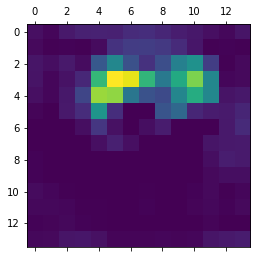

In [7]:
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

## Combine heatmap and original image

In [8]:
# Read image with OpenCV
img = cv2.imread(original_img_path)
new_img_path ="combined_images/Golden_retriever.jpg"

# Resize heatmap to original image size
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# Convert to rgb
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Apply heatmap
superimposed_img = heatmap * 0.6 + img

# Save the combined image
cv2.imwrite(new_img_path, superimposed_img)

True

## Visualize combined image

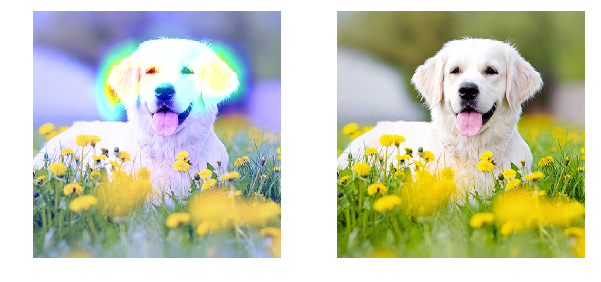

In [9]:
img_new = mpimg.imread(new_img_path)
img = mpimg.imread(original_img_path)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax1.axis('off')
ax2.axis('off')
ax1.imshow(img_new)
ax2.imshow(img)